# Introduction 

Vector database management systems store vectors of data, such as embeddings or spectra, in a way that allows for efficient querying and manipulation. This is useful for a wide range of applications, such as machine learning, data mining, and signal processing.

In this notebook, we will add a few spectra from the SOP Spectra Library and load them into the LanceDB vector database and search for similar spectra. 

## Dataset Background 
Synthetic Organic Pigments Research Aggregation Network
https://soprano.kikirpa.be/

Creative Commons License
This dataset is licensed under a Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International License.


In [17]:

import pandas as pd
import lancedb
from pathlib import Path
import matplotlib.pyplot as plt
import pyarrow as pa
from scipy import signal
import numpy as np

In [18]:
def load_spectrum_df(path: str| Path) -> pd.DataFrame:
    return pd.read_csv(path, 
                 skiprows=39,
                 header=None, 
                 names=["raman_shift", "intensity"],
                 dtype={"raman_shift": float, 'intensity': float}).assign(filename=Path(path).stem)


In [19]:
def resample_spectrum(spectrum: pd.DataFrame, left_clip: float, right_clip: float) -> pd.DataFrame:
    intensity_vector = signal.resample(spectrum.set_index("raman_shift").sort_index().loc[left_clip:right_clip].intensity.to_numpy(), right_clip - left_clip)
    new_wave_numbers = np.linspace(left_clip, right_clip, right_clip - left_clip, endpoint=False)
    filenames = [spectrum.filename.iloc[0]] * len(new_wave_numbers)
    return pd.DataFrame({"raman_shift": new_wave_numbers, "intensity": intensity_vector, "filename": filenames})
    

In [20]:
spectrum = load_spectrum_df('data/spectra/PR1_E_785_kikirpa_baseline corrected.csv')

<Axes: xlabel='raman_shift'>

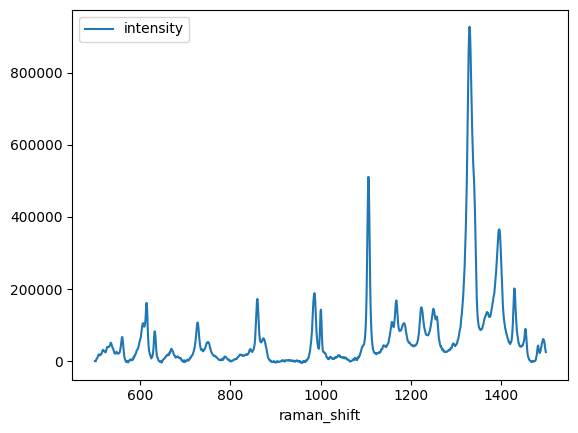

In [21]:
resample_spectrum(spectrum, 500, 1500).plot(x="raman_shift", y="intensity")

In [22]:
spectra = [load_spectrum_df(p) for p in Path("data/spectra/").glob("*.csv")]

Text(0, 0.5, 'Intensity')

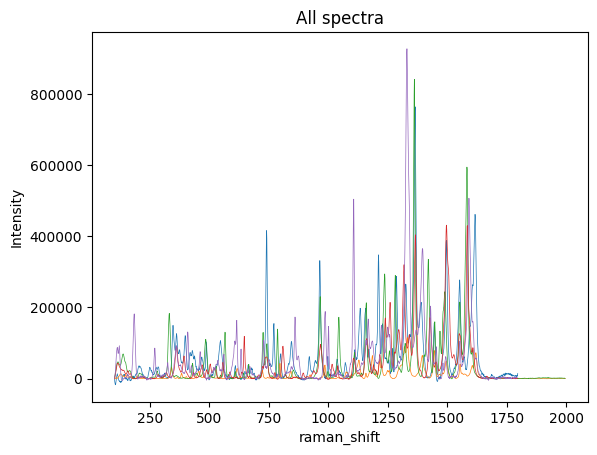

In [23]:
fig, ax = plt.subplots(1,1)
for s in spectra:
    s.plot(x='raman_shift', y='intensity', title='All spectra', kind='line', ax=ax, legend=False, linewidth=0.5)
ax.set_ylabel('Intensity')

In [24]:
resample_spectra = [resample_spectrum(load_spectrum_df(p), 500, 1500) for p in Path("data/spectra/").glob("*.csv")]

In [37]:
def get_record(spectra_df: pd.DataFrame) -> dict:
    return {
        "filename": spectra_df.filename.iloc[0],
     #   "raman_shift": spectra_df.raman_shift.to_numpy(),
        "vector": spectra_df.intensity.to_numpy()  # Note this has to be named vector to work with the lancedb. To use a different name you have to manualyl define the scheam
    }

In [26]:
uri = "data/sample-lancedb"
db = lancedb.connect(uri)

In [27]:
data = [get_record(s) for s in resample_spectra]

In [28]:
tbl = db.create_table("spectra", data=data,  mode="overwrite")

In [29]:
tbl.count_rows()

5

In [30]:
tbl.head()

pyarrow.Table
filename: string
vector: fixed_size_list<item: float>[1000]
  child 0, item: float
----
filename: [["PR18_A_785_kikirpa_baseline corrected","PR3_A_785_kikirpa_baseline corrected","PR2_A_785_kikirpa_baseline corrected","PR5_A_785_kikirpa_baseline corrected","PR1_E_785_kikirpa_baseline corrected"]]
vector: [[[4291.905,-486.57608,4737.1133,4766.3994,9695.378,...,380947.9,389046.66,378604.22,343371.75,300030.84],[6780.976,6440.9673,7537.0684,7316.525,7053.191,...,49547.414,46849.21,43342.105,38118.812,34387.31],[8093.128,5196.4717,4869.185,4329.793,5521.0723,...,140332.6,118535.27,99245.8,80970.805,66945.62],[38207.09,35674.754,41365.414,40384.785,38721.88,...,426675.72,431316.3,422484.1,400120.8,377893.66],[720.07404,695.8997,97.7991,4828.2817,7281.8647,...,57861.67,52016.28,41418.36,33956.11,25542.727]]]

In [36]:
print('actual', data[0]['filename'], 'predicted', tbl.search(np.array(data[0]['vector'])).limit(1).to_list()[0]['filename'])

actual PR18_A_785_kikirpa_baseline corrected predicted PR18_A_785_kikirpa_baseline corrected


## Add Noise 

In [ ]:
v = tbl.search(np.array(data[0]['vector'])).limit(1).to_list()[0]['filename']
print(data[0]['filename'], tbl.search(np.array(data[0]['vector'])).limit(1).to_list()[0]['filename'])